<a href="https://colab.research.google.com/github/abeyp/sf-film-locations/blob/main/sf_film_locations_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis on SF Film Locations

Dataset obtained from:

- Google BigQuery Public Data: 

Using SQL and Pandas

Goal of exploratory data analysis is to develop an understanding of our data. 

## Dataset Description: 


Schema:
*   Title
*   release_year
*   locations
*   production_company
*   distributor
*   director
*   writer
*   actor_1
*   actor_2
*   actor_3

We can look at 
- the number of releases each year and see the trend of movie growth over the years and how the running total may look as well for sharp increases. 
- Look into top locations over all or for each year
Top production company's and distributors
- Looking ahead, we could combine another dataset to understand if any movies ranked highly overall or received awards.

In [8]:
#Authenticate colab

from google.colab import auth
auth.authenticate_user()
print('Authenticated')
# %unload_ext google.colab.data_table

Authenticated


In [10]:
# My Google Cloud Project

project_id = 'elated-bus-316920'

## Data Prepping and Cleanning

Quick Notes: 
- GBQ Schema noted `release_year` as an `INTEGAR`...need to change to `DATETIME` if I want to work with years or decades overview

- Need to check for any null values as GBQ Schema notied `NULLABLE`
- lowercase all the text to help with seaching through categorical variables (Options here include creating my own function or using NLTK package)


In [11]:
# Import BigQuery through google-cloud-bigquery

from google.cloud import bigquery

client = bigquery.Client(project=project_id)

#View number of rows in our dataset
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `elated-bus-316920.sf_bq_copy.san_francisco_film_locations`''').to_dataframe().total[0]

print('Full dataset has %d rows' % row_count)

Full dataset has 3414 rows


In [14]:
#Creating Pandas DataFrame

df = client.query('''
  SELECT
    *
  FROM
    `elated-bus-316920.sf_bq_copy.san_francisco_film_locations`''').to_dataframe()

In [15]:
df.head()

,title,release_year,locations,fun_facts,production_company,distributor,director,writer,actor_1,actor_2,actor_3
0,A Jitney Elopement,1915,20th and Folsom Streets,None,The Essanay Film Manufacturing Company,General Film Company,Charles Chaplin,Charles Chaplin,Charles Chaplin,Edna Purviance,None
1,A Jitney Elopement,1915,Golden Gate Park,"During San Francisco's Gold Rush era, the Park...",The Essanay Film Manufacturing Company,General Film Company,Charles Chaplin,Charles Chaplin,Charles Chaplin,Edna Purviance,None
2,A Jitney Elopement,1915,Golden Gate Park,"During San Francisco's Gold Rush era, the Park...",The Essanay Film Manufacturing Company,General Film Company,Charles Chaplin,Charles Chaplin,Charles Chaplin,Edna Purviance,None
3,A Jitney Elopement,1915,20th and Folsom Streets,None,The Essanay Film Manufacturing Company,General Film Company,Charles Chaplin,Charles Chaplin,Charles Chaplin,Edna Purviance,None
4,Greed,1924,Cliff House (1090 Point Lobos Avenue),"In 1887, the Cliff House was severely damaged ...",Metro-Goldwyn-Mayer (MGM),Metro-Goldwyn-Mayer (MGM),Eric von Stroheim,Eric von Stroheim,Zasu Pitts,Gibson Gowland,Jean Hersholt


In [42]:
#TODO: Check for null values

# Exploratory Analysis

We have all categorical data. What can we do with categorical data?

In [38]:
# Import Packages
import pandas as pd
import matplotlib.pyplot as plt


In [43]:
# TODO: Summary Statistics we can pull for general overview of categorical data before going into the questions...

## How many distinct movies were shot each year in SF?

- year | total_titles

- year, count(distinct titles), group by the year, order by 2 desc

In [37]:
count_per_year = client.query('''
  SELECT
      release_year,
      COUNT(DISTINCT title) as total_titles
  FROM
    `elated-bus-316920.sf_bq_copy.san_francisco_film_locations`
  #WHERE release_year >= 2000 and release_year <= 2010
  GROUP BY 1
  ORDER BY 1 DESC
  ''').to_dataframe()
count_per_year

,release_year,total_titles
0,2019,4
1,2018,5
2,2017,7
3,2016,16
4,2015,23
...,...,...
71,1936,2
72,1935,1
73,1927,1
74,1924,1


How to check if numbers are correct?

Also noticed there are Movies and TV Shows in the film locations dataset. something to look into another time if I am able to find another dataset to join

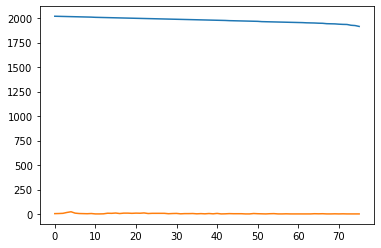

In [28]:
## TODO: forgot matplotlib, please do later!
  # visualize count of titles
  
plt.plot(count_per_year)
plt.show()

### What is the number of titles each decade? 

In [ ]:
#TODO: hard to extract the decade from the release_year (int)

## What is the running total for titles filmed in SF?

In [32]:
running_title_total = client.query('''
WITH titles_by_year AS 
(
SELECT
      release_year,
      COUNT(DISTINCT title) as num_titles
  FROM
    `elated-bus-316920.sf_bq_copy.san_francisco_film_locations`
  GROUP BY 1
)
SELECT *,
    SUM(num_titles) OVER(ORDER BY release_year) as cumulative_titles
FROM titles_by_year
 ''').to_dataframe()
running_title_total

,release_year,num_titles,cumulative_titles
0,1915,1,1
1,1924,1,2
2,1927,1,3
3,1935,1,4
4,1936,2,6
...,...,...,...
71,2015,23,284
72,2016,16,300
73,2017,7,307
74,2018,5,312


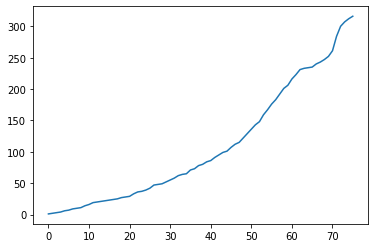

In [36]:
## TODO: Finish Viz

plt.plot(running_title_total['cumulative_titles'])
plt.show()

We can see in the running total of titles, there is a sharp increase in titles as it curves up. A slight plataeu that sharply increases much more drastically in recent years. 

## What are the most popular SF film locations?


In [64]:
# How many distinct SF Locations are there? 
len(df['locations'].value_counts())

1400

In [66]:
#checking against SQL 

num_distinct_sf_locations = client.query('''
SELECT COUNT(DISTINCT locations) as num_of_locations
FROM `elated-bus-316920.sf_bq_copy.san_francisco_film_locations`
WHERE locations IS NOT NULL''').to_dataframe()
num_distinct_sf_locations

,num_of_locations
0,1400


In [51]:
# Count of mentioned locations 
df['locations'].value_counts()

Golden Gate Bridge                             54
City Hall                                      45
Fairmont Hotel (950 Mason Street, Nob Hill)    41
Treasure Island                                28
Coit Tower                                     22
                                               ..
Terry A. Francois Blvd.                         1
Grant Ave btwn Clay and Jackson                 1
Powell St btwn North Point and Embarcadero      1
Russian Hill                                    1
Bush St at Mason St                             1
Name: locations, Length: 1400, dtype: int64

LIMITATIONS: slight differences in text. 
For example, Golden Gate Bridge being lowercase vs uppercase, having '-'

In NLTK Package: 
Tokeniation and stem each work in a list and rejoin on a space character. 

## Who are the top producers and distributors in our dataset?

Top production company's and distributors

In [67]:
df.head(3)

,title,release_year,locations,fun_facts,production_company,distributor,director,writer,actor_1,actor_2,actor_3
0,A Jitney Elopement,1915,20th and Folsom Streets,None,The Essanay Film Manufacturing Company,General Film Company,Charles Chaplin,Charles Chaplin,Charles Chaplin,Edna Purviance,None
1,A Jitney Elopement,1915,Golden Gate Park,"During San Francisco's Gold Rush era, the Park...",The Essanay Film Manufacturing Company,General Film Company,Charles Chaplin,Charles Chaplin,Charles Chaplin,Edna Purviance,None
2,A Jitney Elopement,1915,Golden Gate Park,"During San Francisco's Gold Rush era, the Park...",The Essanay Film Manufacturing Company,General Film Company,Charles Chaplin,Charles Chaplin,Charles Chaplin,Edna Purviance,None


In [76]:
df['production_company'].value_counts(ascending=False).head(10)

Mission Street Productions, LLC           250
Warner Bros. Pictures                     198
Paramount Pictures                        182
TVM Productions                           168
Turner North Center Productions           116
Unpronounceable Productions, LLC           84
The Malpaso Company                        60
TVM Productions Inc.                       60
Twentieth Century Fox Film Corporation     56
Orion Pictures Corp.                       56
Name: production_company, dtype: int64

In [75]:
df['distributor'].value_counts(ascending=False).head(10)

Warner Bros. Pictures              300
Paramount Pictures                 298
Netflix                            202
HBO                                186
HULU                               168
Turner Network Television (TNT)    116
Buena Vista Pictures               104
Sony Pictures Classics             102
Columbia Pictures                   98
Universal Pictures                  96
Name: distributor, dtype: int64

## Empty - Ideas

Maybe show more skills in seaching for text among directors and actors